### MCA8秒値を使う場合
- 軌道データはMCAの時間分解能に合わせて補間

In [34]:
import akebono
import pytplot
import xarray as xr
import numpy as np

akebono.orb(['1990-02-11', '1990-02-12'])
akebono.vlf_mca(['1990-02-11', '1990-02-12'],datatype='pwr',
                del_invalid_data=['off', 'bit rate m'])

mlatDataAry = pytplot.data_quants['akb_orb_mlat']
LDataAry = pytplot.data_quants['akb_orb_L']
invDataAry = pytplot.data_quants['akb_orb_inv']
Epwr = pytplot.data_quants['akb_mca_Emax_pwr']
Bpwr = pytplot.data_quants['akb_mca_Bmax_pwr']

# 軌道データを補間
mlatDataAryIntrp = mlatDataAry.interp_like(Epwr)
LDataAryIntrp = LDataAry.interp_like(Epwr)
invDataAryIntrp = invDataAry.interp_like(Epwr)

# 軌道データと波動データを結合
pwrDataset = xr.merge([Epwr, Bpwr, mlatDataAryIntrp, LDataAryIntrp, invDataAryIntrp])

# mlatでフィルタリング
mlatRange = [40, 60]
pwrDataset = pwrDataset.where((pwrDataset['akb_orb_mlat'] > mlatRange[0]) & (pwrDataset['akb_orb_mlat'] < mlatRange[1]), drop=True)

21-Feb-24 02:09:48: File is current: ../akebono_data/orbit/daily/199002/ED900211.txt
21-Feb-24 02:09:48: Local file: ../akebono_data/vlf/mca/h1/ave8s/1990/ak_h1_mca_19900211_v02.cdf exists.


In [21]:
pwrDataset

<xarray.Dataset>
Dimensions:           (time: 2222, v_dim: 16)
Coordinates:
  * time              (time) datetime64[ns] 1990-02-11T00:57:08 ... 1990-02-1...
    spec_bins         (v_dim) float32 3.16 5.62 10.0 ... 5.62e+03 1e+04 1.78e+04
    v                 (v_dim) float32 3.16 5.62 10.0 ... 5.62e+03 1e+04 1.78e+04
Dimensions without coordinates: v_dim
Data variables:
    akb_mca_Emax_pwr  (time, v_dim) float64 nan nan nan ... 7.943e-09 3.981e-08
    akb_mca_Bmax_pwr  (time, v_dim) float64 nan nan nan ... 0.0001259 5.012e-05
    akb_orb_mlat      (time) float64 40.15 40.38 40.61 ... 40.28 40.17 40.05
    akb_orb_L         (time) float64 2.911 2.937 2.962 ... 4.158 4.142 4.126
    akb_orb_inv       (time) float64 54.14 54.32 54.5 ... 60.65 60.58 60.52
Attributes:
    plot_options:  {'xaxis_opt': {'axis_label': 'Time', 'crosshair': 'X', 'x_...

In [35]:
import os
time = pwrDataset['time'].values
EmaxAry = pwrDataset['akb_mca_Emax_pwr'].values
BmaxAry = pwrDataset['akb_mca_Bmax_pwr'].values
mlatAry = pwrDataset['akb_orb_mlat'].values
LAry = pwrDataset['akb_orb_L'].values
invAry = pwrDataset['akb_orb_inv'].values

saveDir = 'execute/mca/'
os.makedirs(saveDir, exist_ok=True)

# 特定の周波数帯のデータを抽出
# 周波数はインデックスで指定
freqList = [3.16, 5.62, 10.0, 17.8, 31.6, 56.2, 100, 178, 316, 562, 1000, 1780, 3160, 5620, 10000, 17800]
freqIdxList = [13, 14]
# csvに出力
with open(saveDir+'output.csv', 'w') as f:
    header = ['time', 'mlat', 'L', 'inv']
    for freqIdx in freqIdxList:
        header.append(f'Emax_{freqList[freqIdx]}')
        header.append(f'Bmax_{freqList[freqIdx]}')
    f.write(','.join(header)+'\n')
    for i in range(len(time)):
        row = [str(time[i])]
        row.append(str(mlatAry[i]))
        row.append(str(LAry[i]))
        row.append(str(invAry[i]))
        for freqIdx in freqIdxList:
            row.append(str(EmaxAry[i, freqIdx]))
            row.append(str(BmaxAry[i, freqIdx]))
        f.write(','.join(row)+'\n')


### csvファイルを読み込んでプロット

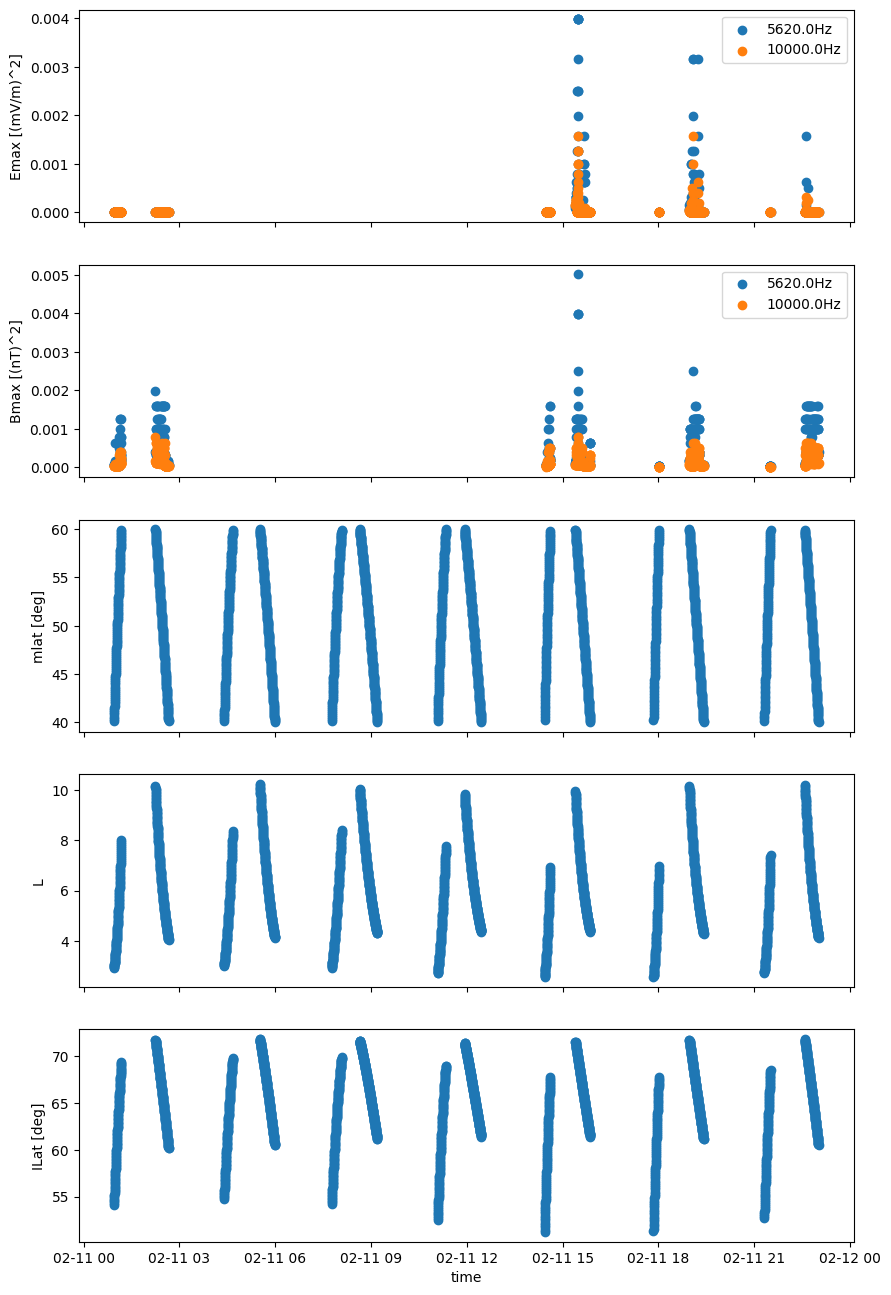

In [2]:
# csvファイルの読み込み
import pandas as pd
saveDir = 'execute/mca/'
df = pd.read_csv(saveDir+'output.csv')

time = df['time'].values
time = pd.to_datetime(time)
mlat = df['mlat'].values
L = df['L'].values
inv = df['inv'].values
# Emax_*とBmax_*の列を抽出
Emax = df.iloc[:, 4::2].values # 4列目以降を2列おきに抽出
Bmax = df.iloc[:, 5::2].values # 5列目以降を2列おきに抽出
# Emax_*の列名を抽出
EmaxColNames = df.columns[4::2].values
# 周波数を抽出
freqList = [float(col[5:]) for col in EmaxColNames]

# プロット
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(10, 16), sharex=True)
for i in range(len(Emax[0])):
    axs[0].scatter(time, Emax[:, i], label=f'{freqList[i]}Hz')
    axs[1].scatter(time, Bmax[:, i], label=f'{freqList[i]}Hz')
axs[2].scatter(time, mlat)
axs[3].scatter(time, L)
axs[4].scatter(time, inv)

axs[0].set_ylabel('Emax [(mV/m)^2]')
axs[1].set_ylabel('Bmax [(nT)^2]')
axs[2].set_ylabel('mlat [deg]')
axs[3].set_ylabel('L')
axs[4].set_ylabel('ILat [deg]')
axs[4].set_xlabel('time')
axs[0].legend()
axs[1].legend()
plt.show()
